# GPS Code Processing

Εξίσωση Παρατήρησης Κώδικα:
$$ P_{j, rec}^{sat} = \rho _{rec}^{sat} + c \dot (\delta t_{rec} - \delta t^{sat}) + \delta T + \delta I_{j, rec}^{sat} + \epsilon_{j,rec}^{sat} $$
με

* $j$ = 1,2,5
* $\rho _{rec}^{sat} = \rho(t) _{rec}^{sat} = \sqrt((x^{sat}-x_{rec})^2+(z^{sat}-z_{rec})^2+(z^{sat}-z_{rec})^2)$,
* $\delta t_{rec}$ το σφάλμα χρονομέτρου του δέκτη,
* $\delta t^{sat}$ το σφάλμα χρονομέτρου του δορυφόρου,
* $\delta T$ σφάλμα (καθυστέρηση) λόγω τροπόσφαιρας,
* $\delta I$ σφάλμα (καθυστέρηση) λόγω ιονόσφαιράς,
* $\epsilon$ εναπομείναντα σφάλματα

Θα χρειαστούμε:
* ένα (data) RINEX v3.x αρχείο, με τις παρατηρήσεις ενός σταθμού

In [1]:
# set the name of the (GNSS) RINEX file to use
rinex_fn = "../../data/DYNG00GRC_R_20240010000_01D_30S_MO.rnx"

* ένα sp3[cd] αρχείο, με τροχιές δουρφόρων GPS που να καλύπτει το διάστημα των παρατηρήσεων του αρχείου RINEX

In [2]:
# set the name of the Sp3 file for the same satellite, covering the same day
sp3_fn = "../../data/COD0MGXFIN_20240010000_01D_05M_ORB.SP3"

* τις παρακάτω βιβλιοθήκες της Python

In [3]:
from dsoclasses.orbits import sp3c, interpolator
from dsoclasses.geodesy import transformations
from dsoclasses.gnss import systems as gs
from dsoclasses.rinex.gnss.rinex import GnssRinex, fetch
from dsoclasses.troposphere import gmf, gpt3
from dsoclasses.time.pyattotime import at2pt, fsec2asec
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

## Παρεμβολή Τροχιών και Διορθώσεων Χρονομέτρων των Δορυφόρων

Για να επεξεργαστούμε τις παρατηρήσεις GPS, θα χρειστούμε τις συν/νες των δορυφόρων, καθώς και τις διορθώσεις των ρολογιών τους, στις εποχές των μετρήσεων. Θα χρησιμοποιήσουμε τις καταγραφές του αρχείου sp3, και έναν αλγόριθμο παρεμβολής για να τις υπολογίσουμε.
```
intrp = interpolator.Sp3Interpolator(sp3_fn, ['G'], 3600, 10, 'CubicSpline', True, ['M', 'E'])
```
Η παραπάνω γραμμή, θα δημιουργήσει ένα αντικείμενο τύπου `Sp3Interpolator` με βάση το αρχείο sp3 `sp3_fn`. Για να πάρουμε τις συν/νες και τη διόρθωση του ρολογιού σε τυχαία εποχή $t$, μπορούμε να γράψουμε:
```
x,y,z,clk = intrp.sat_at(sat, t)
```
όπου `sat` είναι το αναγνωριστικό του δορυφόρου (π.χ. 'G21').

In [4]:
intrp = interpolator.Sp3Interpolator(sp3_fn, ['G'], 3600, 10, 'CubicSpline', True, ['M', 'E'])

Skipping sp3 record for satellite G01: missing clock value ([nan])
Skipping sp3 record for satellite G02: missing clock value ([nan])
Skipping sp3 record for satellite G03: missing clock value ([nan])
Skipping sp3 record for satellite G04: missing clock value ([nan])
Skipping sp3 record for satellite G05: missing clock value ([nan])
Skipping sp3 record for satellite G06: missing clock value ([nan])
Skipping sp3 record for satellite G07: missing clock value ([nan])
Skipping sp3 record for satellite G08: missing clock value ([nan])
Skipping sp3 record for satellite G09: missing clock value ([nan])
Skipping sp3 record for satellite G10: missing clock value ([nan])
Skipping sp3 record for satellite G11: missing clock value ([nan])
Skipping sp3 record for satellite G12: missing clock value ([nan])
Skipping sp3 record for satellite G13: missing clock value ([nan])
Skipping sp3 record for satellite G14: missing clock value ([nan])
Skipping sp3 record for satellite G15: missing clock value ([n

# Γραφική Παράσταση παρατήρησης κώδικα P1 για τον δορυφόρο G21

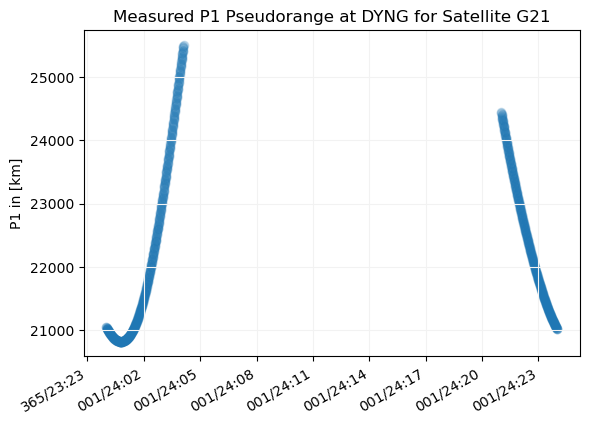

In [5]:
# Δημιουργούμε ένα αντικείμενο τύπου GnssRinex
rnx = GnssRinex(rinex_fn)

# κενές λίστες για τον χρόνο και την P1
epochs = []; p1s = [];

# Για κάθε data block του αρχείου RINEX (επανάλληψη)
for block in rnx:
    # εποχή/χρόνος παρατήρησης (σύμφωνα με το χρονόμετρο του δέκτη)
    t = block.t()
    # για κάθε δουρφόρου του συστήματος GPS που εμπεριέχεται στο data block (επανάλληψη)
    for sat, obs in block.filter_satellite_system("gps", False):
        # θέλουμε τον δορυφόρο 'G21'
        if sat == 'G21':
            # θέλουμε την παρατήρηση του κώδικα στην L1 συχνότητα σε km (αν υπάρχει)
            try:
                p1 = fetch(obs, 'C1W', 'C1C', 'C1X')['value']
                epochs.append(at2pt(t)); p1s.append(p1*1e-3);
            except:
                pass

# Γραφική αναπαράσταση (χρόνος P1)
fig, ax = plt.subplots()
ax.scatter(epochs, p1s, alpha=0.2)
ax.grid(color='0.95')
plt.ylabel("P1 in [km]")
plt.title("Measured P1 Pseudorange at {:} for Satellite {:}".format(rnx.marker_name, 'G21'))
hours = mdates.HourLocator(interval = 3)
h_fmt = mdates.DateFormatter('%j/%y:%H')
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)
fig.autofmt_xdate()
plt.show()

## Γεωμετρική Απόσταση Δορυφόρου-Δέκτη

$$\rho _{rec}^{sat} = \rho(t) _{rec}^{sat} = \sqrt((x^{sat}-x_{rec})^2+(z^{sat}-z_{rec})^2+(z^{sat}-z_{rec})^2)$$

H "ψευδοαπόσταση" είναι η γεωμετρική απόσταση μεταξύ δορυφόρου την χρονική στιγμή εκπομπής του σήματος και του δέκτη, την χρονική στιγμή της λήψης του.
Οι συν/νες του δορυφόρου, πρέπει να υπολογιστούν για την χρονική στιγμή **εκπομπής** του σήματος και όχι την ώρα **λήψης** (που αναγράφεται στο RINEX). Ο χρόνος που κάνει το σήμα να φτάσει από τον δορυφόρο στον δέκτη, είναι περίπου $\approx .07 [sec]$.

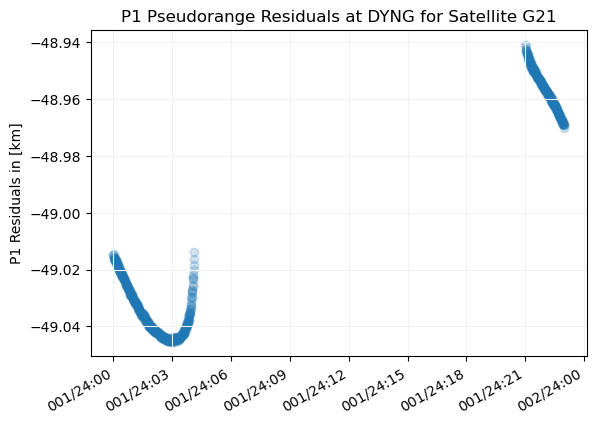

In [6]:
# προσεγγιστικές συν/νες δέκτη (από RINEX)
rsta = np.array(rnx.approx_cartesian())

# Γεωμετρική απόσταση δορυφόρου-δέκτη
def geometric_range(rsat, rrec): return np.linalg.norm(rsat-rrec)

# Συν/νες δορυφόρου την εποχή εκπομπής
def emission_time(rsta, t_reception, interpolator, sat, verbose=0):
    t_emission = t_reception
    x, y, z, clk = interpolator.sat_at(sat, t_emission)
    while True:
        r = geometric_range(np.array((x,y,z)), rsta)
        dt = r / gs.C
        #print("\tFound new dt = {:.9f}".format(dt), end='')
        t_emission = t_reception - fsec2asec(dt)
        xnew, ynew, znew, clk = interpolator.sat_at(sat, t_emission)
        #print("({:.1f} {:.1f} {:.1f})".format(xnew-x,ynew-y,znew-z))
        if abs(xnew-x)<1. and abs(ynew-y)<1. and abs(znew-z)<1.:
            if verbose>0:
                print("[DEBUG] t_emission is {:} and t_reception is {:}".format(t_emission.strftime("%H:%M:%S.%f"), t_reception.strftime("%H:%M:%S.%f")))
            return xnew, ynew, znew, clk
        else:
            x=xnew; y=ynew; z=znew;
# κενές λίστες για τον χρόνο και την P1
epochs = []; p1s = [];

for block in rnx:
    t = block.t()
    for sat, obs in block.filter_satellite_system("gps", False):
        if sat == 'G21':
            try:
                p1 = fetch(obs, 'C1W', 'C1C', 'C1X')['value']
                #συν/νες δουρφόρου την εποχή εκπομπής
                xsat, ysat, zsat, csat = emission_time(rsta, t, intrp, 'G21')
                r = geometric_range(np.array((xsat,ysat,zsat)), rsta)
                p1s.append((p1-r)*1e-3); epochs.append(at2pt(t));
            except:
                pass

# Γραφική αναπαράσταση (χρόνος - υπόλοιπα P1)
fig, ax = plt.subplots()
ax.scatter(epochs, p1s, alpha=0.2)
ax.grid(color='0.95')
plt.ylabel("P1 Residuals in [km]")
plt.title("P1 Pseudorange Residuals at {:} for Satellite {:}".format(rnx.marker_name, 'G21'))
hours = mdates.HourLocator(interval = 3)
h_fmt = mdates.DateFormatter('%j/%y:%H')
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)
fig.autofmt_xdate()
plt.show()

## Διορθώσεις Ρολογιών Δορυφόρων

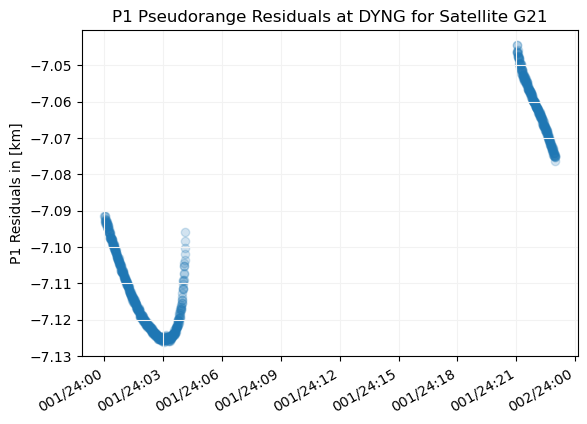

In [7]:
# κενές λίστες για τον χρόνο και την P1
epochs = []; p1s = [];

for block in rnx:
    t = block.t()
    for sat, obs in block.filter_satellite_system("gps", False):
        if sat == 'G21':
            try:
                p1 = fetch(obs, 'C1W', 'C1C', 'C1X')['value']
                #συν/νες δουρφόρου την εποχή εκπομπής
                xsat, ysat, zsat, csat = emission_time(rsta, t, intrp, 'G21')
                r = geometric_range(np.array((xsat,ysat,zsat)), rsta)
                dtsat = gs.C * csat
                p1s.append((p1+dtsat-r)*1e-3); epochs.append(at2pt(t));
            except:
                pass

# Γραφική αναπαράσταση (χρόνος - υπόλοιπα P1)
fig, ax = plt.subplots()
ax.scatter(epochs, p1s, alpha=0.2)
ax.grid(color='0.95')
plt.ylabel("P1 Residuals in [km]")
plt.title("P1 Pseudorange Residuals at {:} for Satellite {:}".format(rnx.marker_name, 'G21'))
hours = mdates.HourLocator(interval = 3)
h_fmt = mdates.DateFormatter('%j/%y:%H')
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)
fig.autofmt_xdate()
plt.show()

## Καθυστέρηση Λόγω Ιονόσφαιρας και Γραμμικοί Συνδυασμοί

Το σφάλμα της ιονόσφαιρας εξαρτάται από το τετράγωνο της συχνότητας (του κύμματος, $a_i = 40.3 / f^2$). Μπορούμε λοιπόν, να απαλείψουμε (σχεδόν) το σφάλμα της ιονόσφαιρας, χρησιμοποιώντας έναν κατάλληλο γραμμικό συνδυασμό των δύο συχνοτήταν του συστήματος:

$$ PC = \frac{f_1^2 P_1 - f_2^2 P_2}{f_1^2 - f_2^2$$

αντίστοιχος συναδυασμός μπορεί να φτιαχτεί και για τις παρατηρήσεις φάσης.

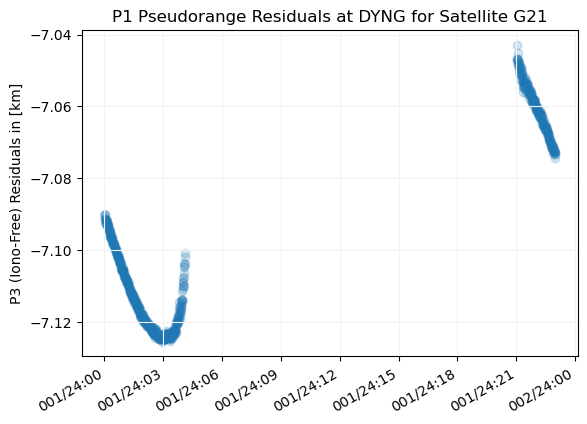

In [15]:
# κενές λίστες για τον χρόνο και την P3
epochs = []; p3s = [];

f1 = gs.GPS_L1_FREQ # MHz
f2 = gs.GPS_L2_FREQ # MHz
fac = f1*f1 - f2*f2

for block in rnx:
    t = block.t()
    for sat, obs in block.filter_satellite_system("gps", False):
        if sat == 'G21':
            try:
                p1 = fetch(obs, 'C1W', 'C1C', 'C1X')['value']
                p2 = fetch(obs, 'C2W', 'C2C', 'C2D', 'C2P', 'C2X', 'C2S', 'C2L')['value']
                # συν/νες δουρφόρου την εποχή εκπομπής
                xsat, ysat, zsat, csat = emission_time(rsta, t, intrp, 'G21')
                r = geometric_range(np.array((xsat,ysat,zsat)), rsta)
                dtsat = gs.C * csat
                # γραμμικός συνδυασμός ελεύθερος ιονόσφαιρας
                pc = f1*f1*p1/fac - f2*f2*p2/fac
                p3s.append((pc+dtsat-r)*1e-3); epochs.append(at2pt(t));
            except:
                pass

# Γραφική αναπαράσταση (χρόνος - υπόλοιπα P3)
fig, ax = plt.subplots()
ax.scatter(epochs, p3s, alpha=0.2)
ax.grid(color='0.95')
plt.ylabel("P3 (Iono-Free) Residuals in [km]")
plt.title("P1 Pseudorange Residuals at {:} for Satellite {:}".format(rnx.marker_name, 'G21'))
hours = mdates.HourLocator(interval = 3)
h_fmt = mdates.DateFormatter('%j/%y:%H')
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)
fig.autofmt_xdate()
plt.show()

In [ ]:
### Επίδραση Ιονόσφαιρας σε Συνάρτηση της Γωνίας Ύψους

In [17]:
# Προσεγγιστικές συν/νες σταθμού από RINEX
site_xyz = rnx.approx_cartesian()
# Μετατροπή σε ελλειψοειδείς συν/νες
lat, lon, hgt = transformations.car2ell(site_xyz[0], site_xyz[1], site_xyz[2])
# Πίνακας στροφής (x, y, z) -> (e, n, u)
Rt = transformations.geodetic2lvlh(lat, lon)
R = Rt.transpose()

In [21]:
def azele(R, rsat, rsta):
    # cartesian difference vector
    dr = rsat - rsta
    # topocentric vector
    enu = R @ (rsat - rsta)
    # compute azimouth and elevation
    r  = np.linalg.norm(enu)
    az = np.arctan2(enu[0], enu[1])
    el = np.arcsin(enu[2] / r)
    return r, az, el

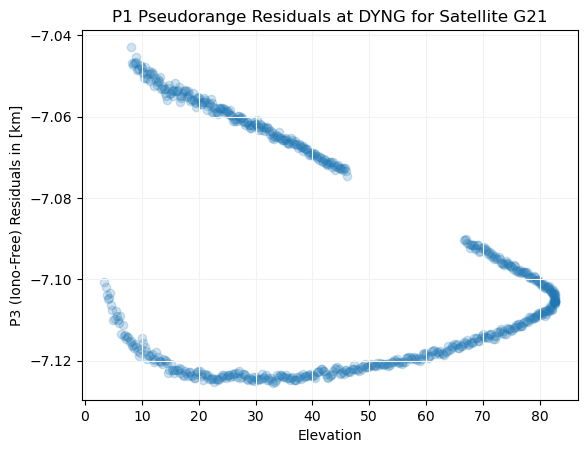

In [33]:
# κενές λίστες για τον χρόνο και την P3
els = []; p3s = [];

for block in rnx:
    t = block.t()
    for sat, obs in block.filter_satellite_system("gps", False):
        if sat == 'G21':
            try:
                p1 = fetch(obs, 'C1W', 'C1C', 'C1X')['value']
                p2 = fetch(obs, 'C2W', 'C2C', 'C2D', 'C2P', 'C2X', 'C2S', 'C2L')['value']
                # συν/νες δουρφόρου την εποχή εκπομπής
                xsat, ysat, zsat, csat = emission_time(rsta, t, intrp, 'G21')
                r = geometric_range(np.array((xsat,ysat,zsat)), rsta)
                dtsat = gs.C * csat
                # γραμμικός συνδυασμός ελεύθερος ιονόσφαιρας
                pc = f1*f1*p1/fac - f2*f2*p2/fac
                # υπολογισμός γωνίας ύψους
                _, _, el = azele(R, np.array((xsat, ysat, zsat)), np.array(site_xyz))
                p3s.append((pc+dtsat-r)*1e-3); els.append(np.degrees(el));
            except:
                pass

# Γραφική αναπαράσταση (γωνία ύψους - υπόλοιπα P3)
fig, ax = plt.subplots()
ax.scatter(els, p3s, alpha=0.2)
ax.grid(color='0.95')
plt.ylabel("P3 (Iono-Free) Residuals in [km]")
plt.title("P1 Pseudorange Residuals at {:} for Satellite {:}".format(rnx.marker_name, 'G21'))
plt.xlabel("Elevation")
plt.show()

## Καθυστέρηση Λόγω Τροπόσφαιρας

$$T = (zhd + zwd) \cdot m(elevation)$$

με

* $T$ καθυστέρηση σε [m],
* $zhd$ καθυστέρηση λόγω του υδροστατικού κομματιού στο ζενίθ,
* $zhd$ καθυστέρηση λόγω του υγρού κομματιού στο ζενίθ,
* $m(elevation)$ συνάρτηση απεικόνισης της καθυστέρησης σε τυχαία γωνία ύψους

$$zhd = 2.3 \exp(-0.116 \cdot 10^{-3} \cdot H) [m]$$
$$zwd = .1 [m]$$
$$m(elevation) = \frac{1.001}{\sqrt(0.002001 + \sin^2(elevation)}$$

Simple Model: ZHD=2.168 ZWD=0.100
GPT3   Model: ZHD=2.191 ZWD=0.074


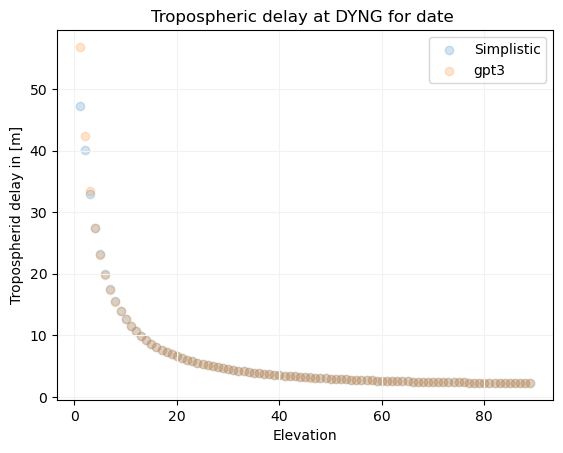

In [40]:
def static_tropo_delay(H): return 2.3 * np.exp(-0.116e-3 * H), .1
    
def tropo_delay(zhd, zwd, el):
    m = 1.001 / np.sqrt(0.002001 + np.sin(el)*np.sin(el))
    return (zhd + zwd) * m

def static_tropo_delay2(t, lat, lon, hgt):
    meteo = gpt3.gpt3(t, lon, lat, hgt, "../../data/gpt3_5.grd")
    zhd = gpt3.saastamoinen_zhd(lat, hgt, meteo['p'])
    zwd = gpt3.askne_zwd(meteo['e'], meteo['Tm'], meteo['la'])
    return zhd, zwd
    
def tropo_delay2(t, lat, lon, hgt, el, zhd, zwd):
    gmfh, gmfw = gmf.gmf(t, lat, lon, hgt, np.pi/2-el)
    return zhd * gmfh + zwd * gmfw

zhd, zwd = static_tropo_delay(hgt)
zhd2, zwd2 = static_tropo_delay2(rnx.time_first_obs, lat, lon, hgt)

print("Simple Model: ZHD={:.3f} ZWD={:.3f}".format(zhd, zwd))
print("GPT3   Model: ZHD={:.3f} ZWD={:.3f}".format(zhd2, zwd2))

trp1 = []; trp2 = []; els = [];
for el in range(1, 90):
    trp1.append(tropo_delay(zhd, zwd, np.radians(el)))
    trp2.append(tropo_delay2(rnx.time_first_obs, lat, lon, hgt, np.radians(el), zhd2, zwd2))
    els.append(el)

# Γραφική αναπαράσταση
fig, ax = plt.subplots()
ax.scatter(els, trp1, alpha=0.2, label="Simplistic")
ax.scatter(els, trp2, alpha=0.2, label="gpt3")
ax.grid(color='0.95')
plt.ylabel("Tropospherid delay in [m]")
plt.title("Tropospheric delay at {:} for date {:}".format(rnx.marker_name, rnx.time_first_obs))
plt.xlabel("Elevation")
ax.legend()
plt.show()

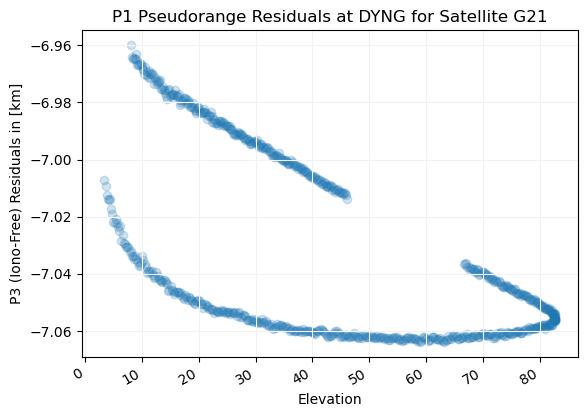

In [43]:
# κενές λίστες για τον χρόνο και την P3
els = []; p3s = [];

# ZHD και ZWD
zhd, zwd = static_tropo_delay2(rnx.time_first_obs, lat, lon, hgt)

for block in rnx:
    t = block.t()
    for sat, obs in block.filter_satellite_system("gps", False):
        if sat == 'G21':
            try:
                p1 = fetch(obs, 'C1W', 'C1C', 'C1X')['value']
                p2 = fetch(obs, 'C2W', 'C2C', 'C2D', 'C2P', 'C2X', 'C2S', 'C2L')['value']
                # συν/νες δουρφόρου την εποχή εκπομπής
                xsat, ysat, zsat, csat = emission_time(rsta, t, intrp, 'G21')
                r = geometric_range(np.array((xsat,ysat,zsat)), rsta)
                dtsat = gs.C * csat
                # γραμμικός συνδυασμός ελεύθερος ιονόσφαιρας
                pc = f1*f1*p1/fac - f2*f2*p2/fac
                # υπολογισμός γωνίας ύψους
                _, _, el = azele(R, np.array((xsat, ysat, zsat)), np.array(site_xyz))
                dT = tropo_delay2(rnx.time_first_obs, lat, lon, hgt, np.radians(el), zhd, zwd)
                p3s.append((pc+dtsat-r+dT)*1e-3); els.append(np.degrees(el));
            except:
                pass

# Γραφική αναπαράσταση (γωνία ύψους - υπόλοιπα P3)
fig, ax = plt.subplots()
ax.scatter(els, p3s, alpha=0.2)
ax.grid(color='0.95')
plt.ylabel("P3 (Iono-Free) Residuals in [km]")
plt.title("P1 Pseudorange Residuals at {:} for Satellite {:}".format(rnx.marker_name, 'G21'))
plt.xlabel("Elevation")
fig.autofmt_xdate()
plt.show()

In [ ]:
## Εκτίμηση Σφάλματος Χρονομέτρου Δέκτη

In [ ]:
def gradient(rsat, rrec): 
    r = np.linalg.norm(rsat-rrec)
    return (rrec-rsat) / r

In [ ]:
# κενές λίστες για τον χρόνο και την P3
els = []; p3s = [];

# ZHD και ZWD
zhd, zwd = static_tropo_delay2(rnx.time_first_obs, lat, lon, hgt)

CUT_OFF_ANGLE = 30 ## degrees

# count number of epochs
num_epochs = 0

# details of each observation
raw_obs = []

for block in rnx:
    t = block.t()
    epoch_used = False
    for sat, obs in block.filter_satellite_system("gps", False):
        try:
            p1 = fetch(obs, 'C1W', 'C1C', 'C1X')['value']
            p2 = fetch(obs, 'C2W', 'C2C', 'C2D', 'C2P', 'C2X', 'C2S', 'C2L')['value']
            # συν/νες δουρφόρου την εποχή εκπομπής
            xsat, ysat, zsat, csat = emission_time(rsta, t, intrp, sat)
            r = geometric_range(np.array((xsat,ysat,zsat)), rsta)
            dtsat = gs.C * csat
            # γραμμικός συνδυασμός ελεύθερος ιονόσφαιρας
            pc = f1*f1*p1/fac - f2*f2*p2/fac
            # υπολογισμός γωνίας ύψους
            _, _, el = azele(R, np.array((xsat, ysat, zsat)), np.array(site_xyz))
            if np.degrees(el) > CUT_OFF_ANGLE:
                dT = tropo_delay2(rnx.time_first_obs, lat, lon, hgt, np.radians(el), zhd, zwd)
                raw_obs.append({'dl': pc+dtsat-r+dT, 'el': el})
                epoch_used = True
        except:
            pass
    num_epochs += int(epoch_used)

# Γραφική αναπαράσταση (γωνία ύψους - υπόλοιπα P3)
fig, ax = plt.subplots()
ax.scatter(els, p3s, alpha=0.2)
ax.grid(color='0.95')
plt.ylabel("P3 (Iono-Free) Residuals in [km]")
plt.title("P1 Pseudorange Residuals at {:} for Satellite {:}".format(rnx.marker_name, 'G21'))
plt.xlabel("Elevation")
fig.autofmt_xdate()
plt.show()